# Check Bounding Boxex NIH

In [4]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile, join
import sys
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from matplotlib import pyplot
from shapely.geometry.polygon import LinearRing, Polygon
# from multiprocessing import Pool
import multiprocessing
import time
import random
sys.path.insert(0, os.path.dirname(os.path.abspath('.'))) # to make imports relative to project root work

First download files from ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/ to folder (see the terminal comand below) e.g.

NIH_NLM_ThinBloodSmears <br>
└-Point Set <br>
└-Polygon Set <br>
Notebooks <br>
└-IH_bounding_boxes.ipynb <br>

In the Terminal navigate to the folder you want your data in (**cd** then drag and drop the folder) then enter following:

wget -r -np ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/

(you might need to install wget with **brew install wget** and if you do not have brew then install homebrew https://brew.sh/)


In [5]:
def get_txt(path):
    list_txt = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".txt"):
                txt_path = os.path.join(root, file)
                list_txt.append(txt_path)
    return list_txt


def txt_to_df(path):
    data_file_delimiter = ','
    df = pd.DataFrame(columns = [ '?','cell', 'comment', 'annotation_type','??', 'position', 'filename', 'txt_path', 'img_path'])
    root, file = os.path.split(path)
    filename, file_extension = os.path.splitext(file)
    txt_path = os.path.join(root, file)
    img_path = os.path.join(root.replace("GT", "Img"), filename +'.jpg')
    # Loop the data lines
    with open(txt_path, 'r') as temp_f:
        # Read the lines
        lines = temp_f.readlines()
        lines.pop(0)
        for l in lines:
            # Count the column count for the current line
            columns = l.split(data_file_delimiter)
            list_locations = [int(float(location)) for location in columns[5:]]
            zip_locations = list(zip(list_locations[1::2], list_locations[::2]))
            df = df.append( {'?': columns[0], 'cell': columns[1], 'comment': columns[2], 'annotation_type': columns[3], \
                '??': columns[4], 'position': zip_locations, 'filename': filename, 'txt_path': txt_path, 'img_path': img_path}, ignore_index = True)
    return df

def collect_results(df_collected):
    """Uses apply_async's callback to setup up a separate Queue for each process"""
    global df
    df = df.append(df_collected)


In [6]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def draw_points(img, cell, annotation, position, row, rows = 1, columns = 1, i = 1, point_size = 15):
    colour = (0,255,0) if cell == 'Uninfected' \
        else (255,0, 0) if cell == 'Parasitized' \
            else (128,0, 128) if cell == 'Platelet' \
                else (0, 0, 255) if cell == 'White_Blood_Cell' \
                    else (255,215,0)

    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(row['filename'])
                    
    if annotation == 'Point':
        cv2.circle(img, position[0], 1, colour, point_size)
    
    elif annotation == 'Polygon':
        if len(position) < 3:
            print('row: ', row)
        if not len(position) < 3:
            poly = Polygon(position)
            x,y = poly.exterior.xy
            ax.plot(x, y, color=rgb_to_hex(colour), alpha=0.7,
                linewidth=3, solid_capstyle='round', zorder=2)


In [7]:
txt_list = get_txt('../NIH-NLM-ThinBloodSmearsPf')
print(len(txt_list))

965


**The following operation takes a while lean back and get a coffee**

In [8]:
df = pd.DataFrame(columns = [ '?','cell', 'comment', 'annotation_type','??', 'position', 'filename', 'txt_path', 'img_path'])
start_time = time.time()  

# Repeats the compute intensive operation on all available cores
pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
pool.map_async(txt_to_df, txt_list, callback = collect_results)
pool.close()
pool.join()

# Converts list of lists to a data frame
print(df.shape)
print("--- %s seconds ---" % (time.time() - start_time))

(250570, 9)
--- 1148.4124820232391 seconds ---


In [ ]:
df.to_csv('labels.csv', index = False)
df

In [17]:
# df = pd.read_csv(gt_path, sep = ',', header = 0, names= [ '?','cell', 'comment', 'annotation_type','??', 'y', 'x'])
df['cell'].value_counts()

Uninfected               229046
Parasitized               10673
Other                      4143
Platelet                   4033
Stain_Precipitation        1078
White_Blood_Cell            542
Debris                      337
Bacteria                    254
Parasite_Outside_Cell       251
Unclear                     111
Dead_Parasite                58
Air_Bubble                   35
Gametocyte                    9
Name: cell, dtype: int64

In [18]:
df['position_len'] = df['position'].apply(lambda x: len(x))
short_polygon = df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] < 3)] 
short_polygon.to_csv('short_polygon.csv', index = False)

In [45]:
filename =  'IMG_20150621_112043'
df_file = df[df['filename'] == filename]

In [20]:
df_file

?         cell     comment annotation_type  ??  \
0    2-212  Parasitized  No_comment         Polygon  14   
1    2-213  Parasitized  No_comment         Polygon  11   
2    2-215   Uninfected  No_comment         Polygon  11   
3    2-216   Uninfected  No_comment         Polygon  12   
4    2-217   Uninfected  No_comment         Polygon  10   
..     ...          ...         ...             ...  ..   
413   2-95   Uninfected  No_Comment           Point   1   
414   2-96   Uninfected  No_Comment           Point   1   
415   2-97   Uninfected  No_Comment           Point   1   
416   2-98   Uninfected  No_Comment           Point   1   
417   2-99   Uninfected  No_Comment           Point   1   

                                              position             filename  \
0    [(1426, 3624), (1407, 3603), (1398, 3582), (13...  IMG_20150621_112043   
1    [(1284, 1446), (1301, 1473), (1307, 1498), (12...  IMG_20150621_112043   
2    [(1541, 2916), (1517, 2951), (1491, 2960), (14...  IMG_20150621_112043   
3    [(1569, 3007), (1551, 2987), (1516, 2982), (14...  IMG_20150621_112043   
4    [(1788, 3104), (1782, 3128), (1720, 3166), (16...  IMG_20150621_112043   
..                                                 ...                  ...   
413                                     [(1027, 1873)]  IMG_20150621_112043   
414                                     [(1127, 1873)]  IMG_20150621_112043   
415                                     [(1051, 1664)]  IMG_20150621_112043   
416                                     [(1124, 1597)]  IMG_20150621_112043   
417                                     [(1167, 1497)]  IMG_20150621_112043   

                                              txt_path  \
0    ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
1    ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
2    ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
3    ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
4    ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
..                                                 ...   
413  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
414  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
415  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
416  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
417  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                                              img_path  position_len  
0    ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...            14  
1    ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...            11  
2    ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...            11  
3    ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...            12  
4    ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...            10  
..                                                 ...           ...  
413  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...             1  
414  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...             1  
415  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...             1  
416  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...             1  
417  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...             1  

[418 rows x 10 columns]

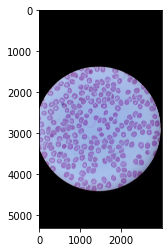

In [21]:
img = cv2.imread(df_file['img_path'][0], cv2.IMREAD_COLOR)
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
img = cv2.flip(img, 1)
plt.imshow(img)

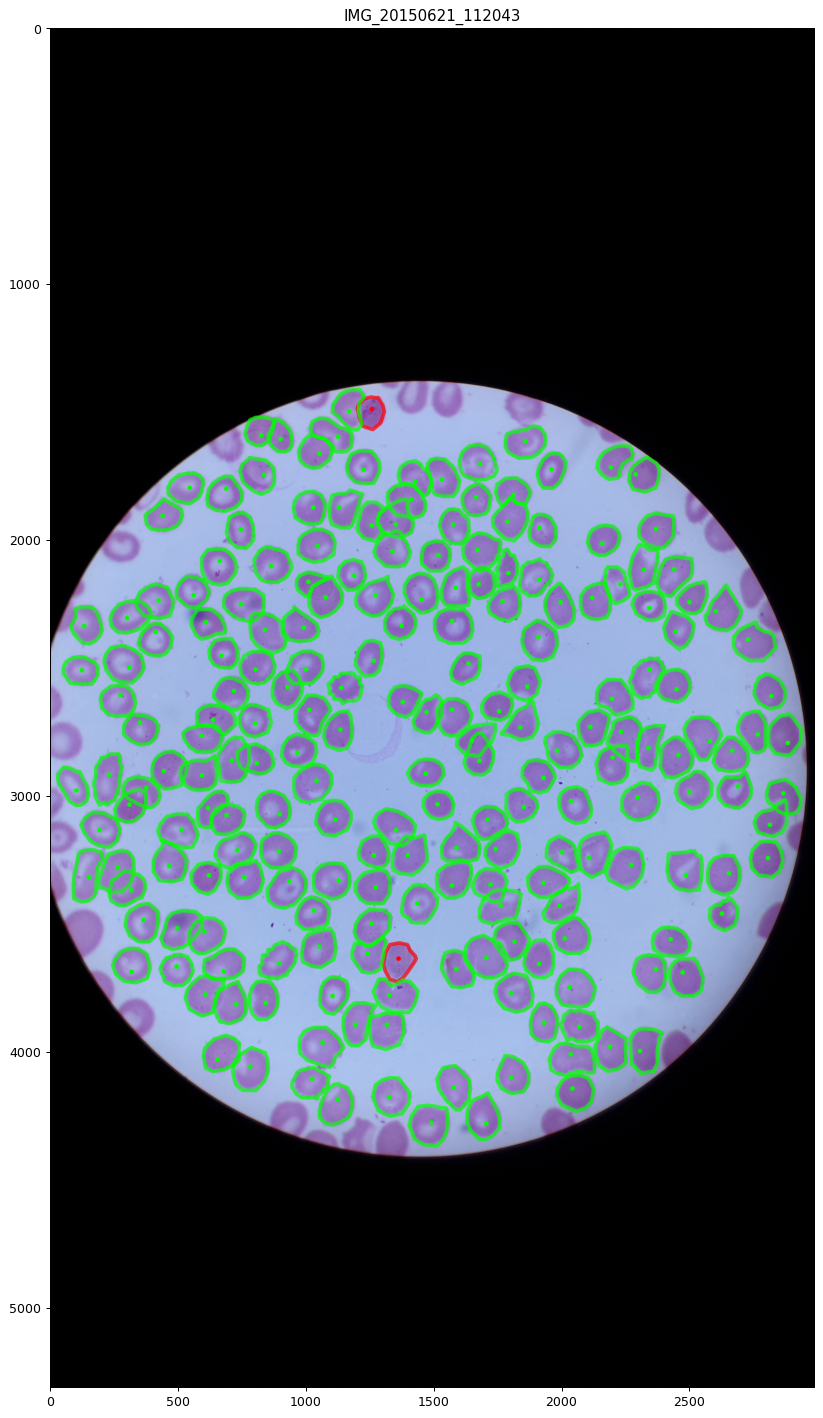

In [22]:
fig = plt.figure(1, figsize=(20,20), dpi=90)
df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row), axis = 1)

row:  ?                                                              2-269
cell                                                     Parasitized
comment                                                   No_comment
annotation_type                                              Polygon
??                                                                 1
position                                              [(1573, 2693)]
filename                                         IMG_20150819_133350
txt_path           ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/209C6...
img_path           ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/209C6...
position_len                                                       1
Name: 58, dtype: object


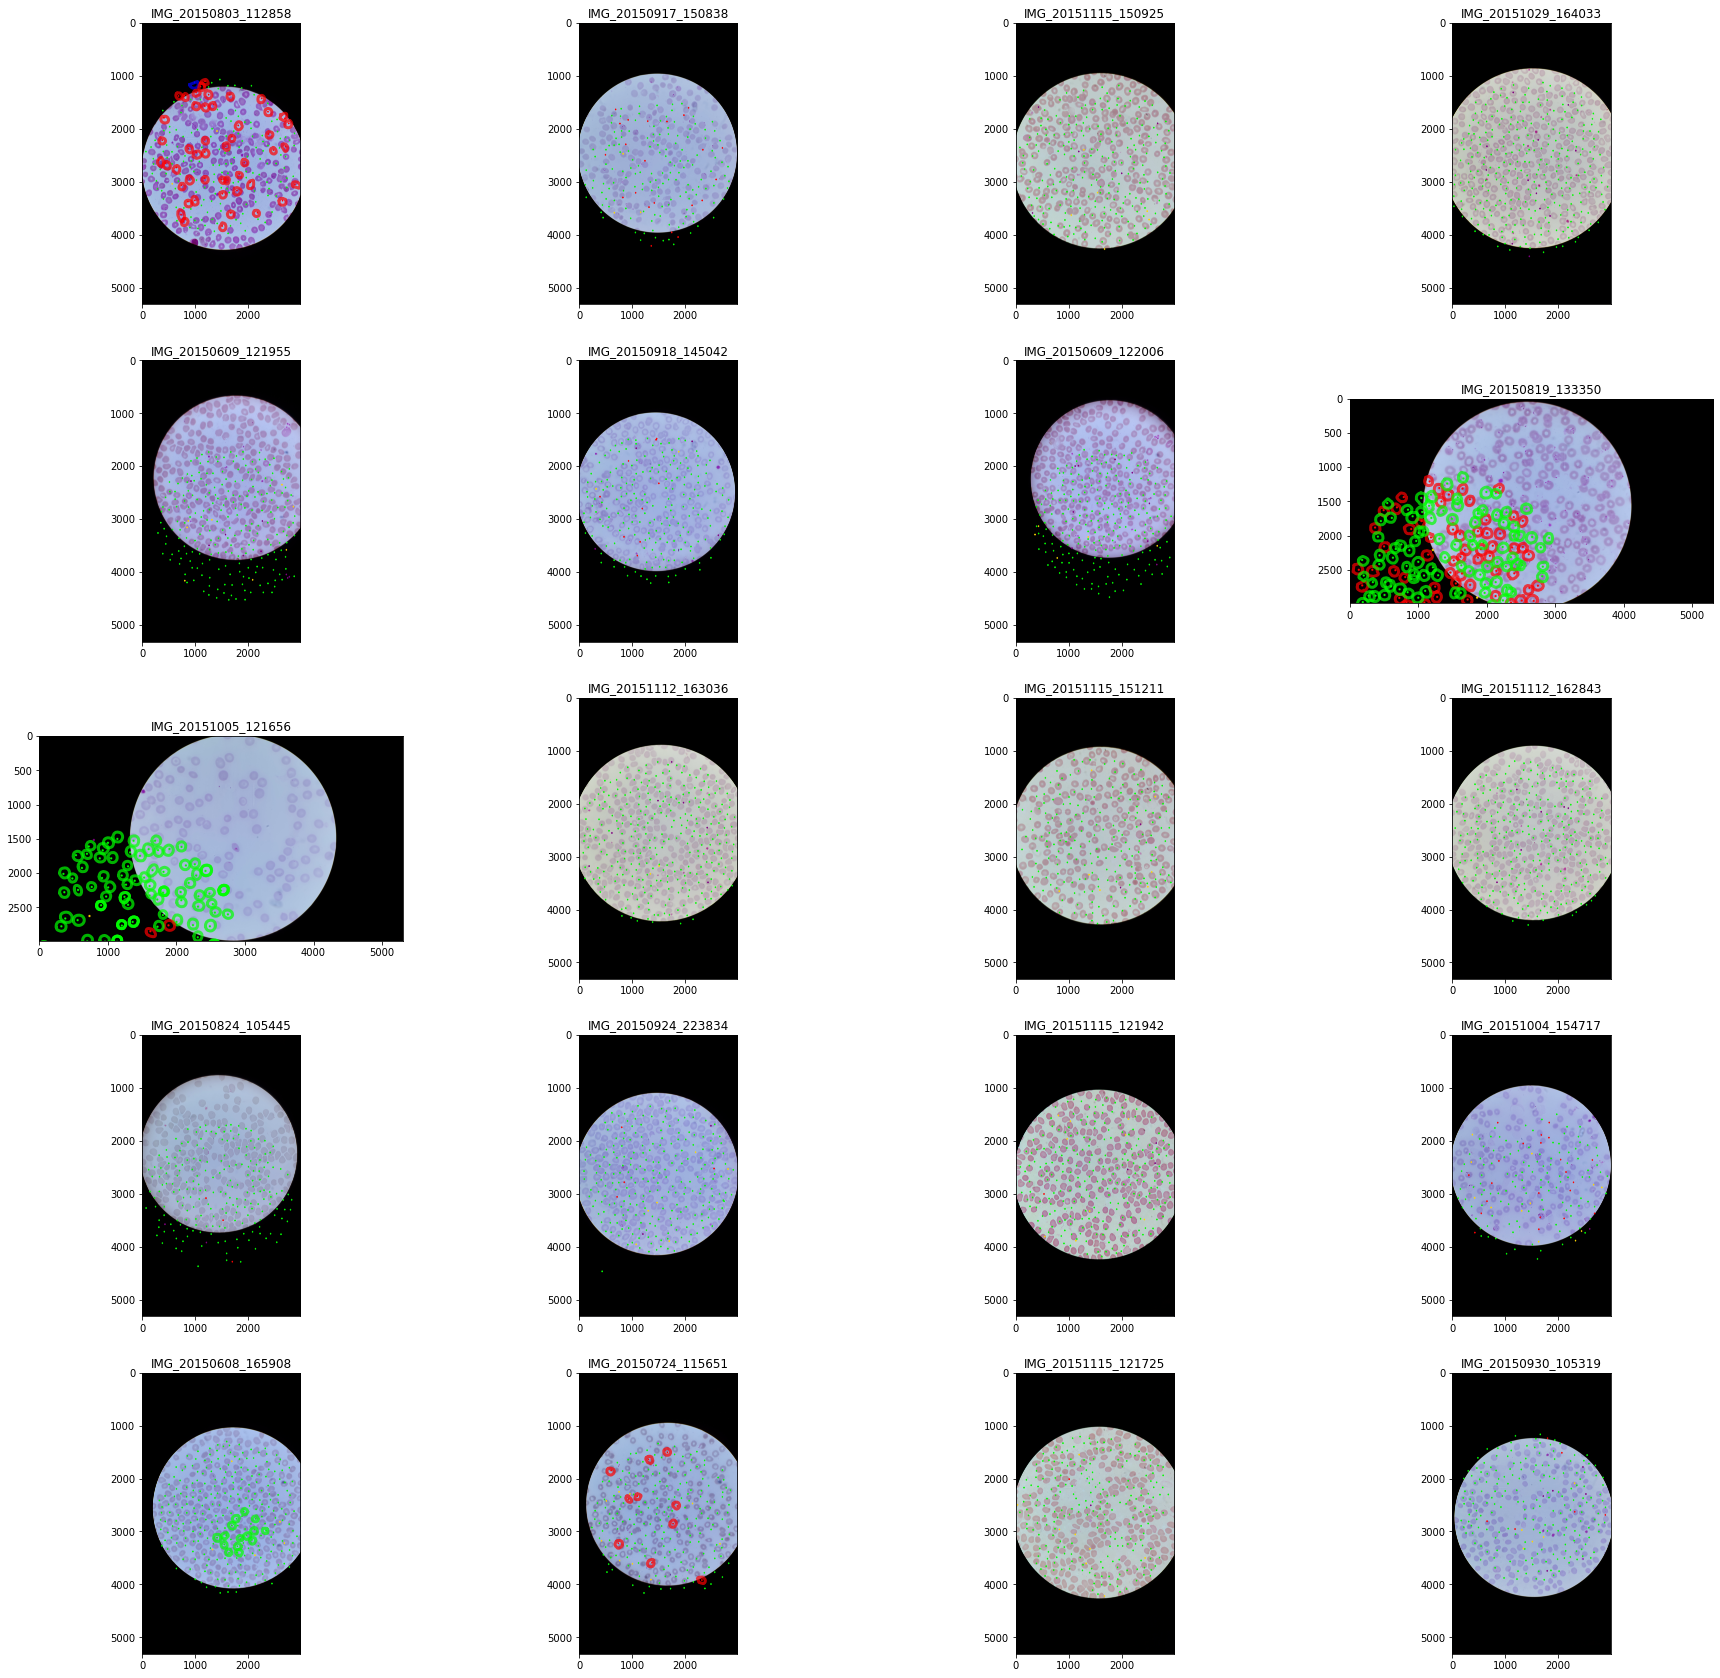

In [23]:
secure_random = random.SystemRandom()

w, h = 10, 10
fig=plt.figure(figsize=(30, 30))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    filename = secure_random.choice(df['filename'].unique())
    df_file = df[df['filename'] == filename]
    #print(filename)
    img = cv2.imread(df_file['img_path'][0], cv2.IMREAD_COLOR)
    df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row = row, rows = rows, columns = columns, i = i, point_size= 30), axis = 1)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Polygons to mask

In [28]:
def poly_mask(row):
    poly = Polygon(row['position'])
    mask = poly.ravel().tolist()

In [36]:
for filename in df['filename'].unique():
    df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] >= 3 ) & (df['filename'] == filename), 'positions'].apply(lambda x: )

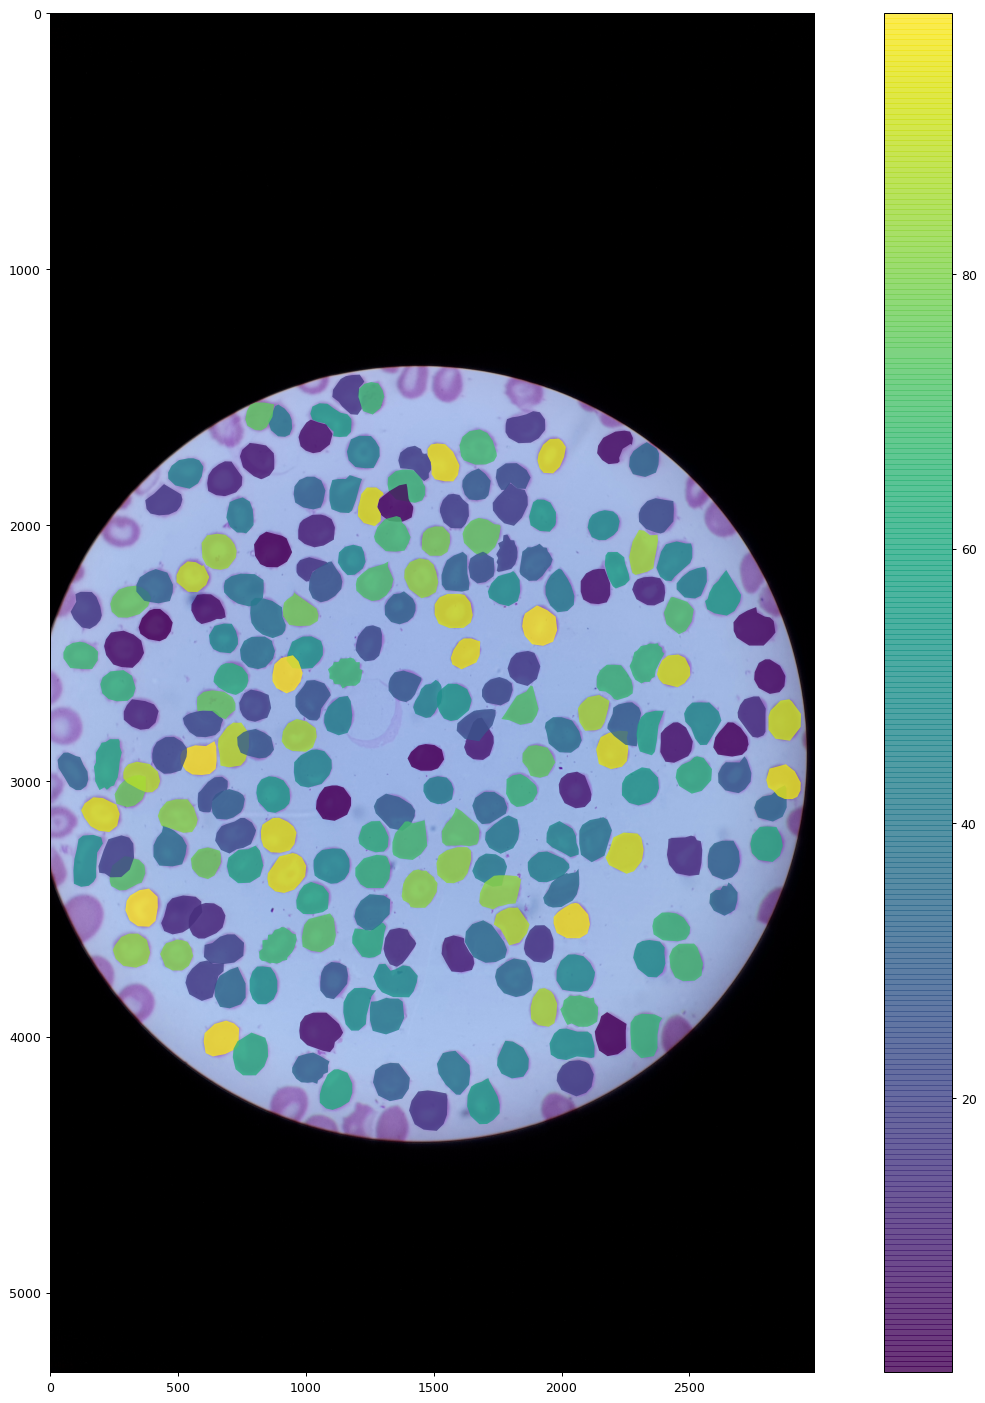

In [113]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib

patches = []
patches = [ Polygon(poly) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] >= 3 ) & (df['filename'] == filename), 'position'] ]

img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] >= 3 ) & (df['filename'] == filename), 'img_path'][0], cv2.IMREAD_COLOR)
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
img = cv2.flip(img, 1)

empty_img = Image.new("L", [img.shape[1], img.shape[0]], 0)
# [ ImageDraw.Draw(img).polygon(poly, outline=1, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] >= 3 ) & (df['filename'] == filename), 'position']]
mask = np.array(empty_img)

fig = plt.figure(1, figsize=(20,20), dpi=90)
ax = fig.add_subplot(111)

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.8)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
plt.imshow(img)


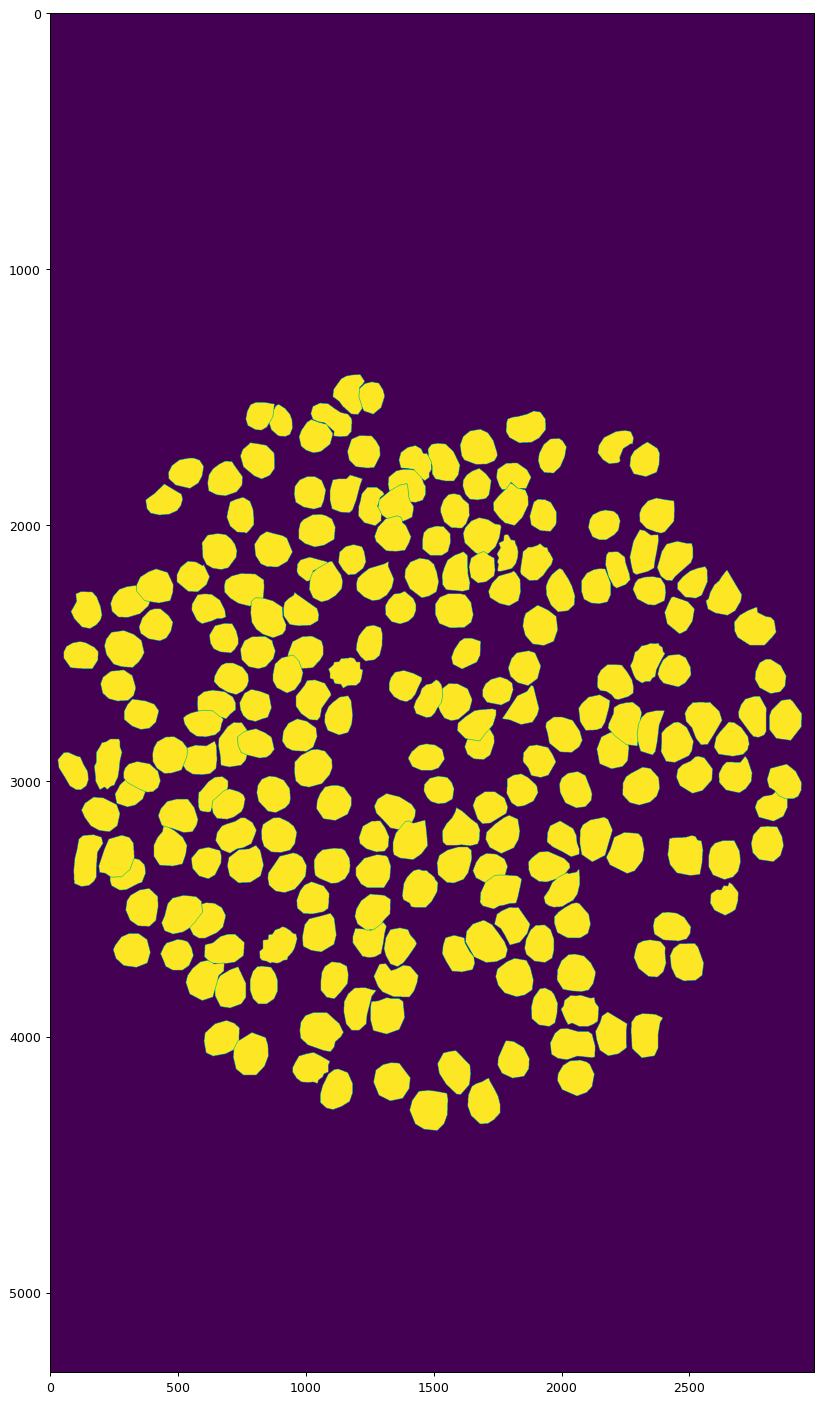

In [115]:

img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] >= 3 ) & (df['filename'] == filename), 'img_path'][0], cv2.IMREAD_COLOR)
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
img = cv2.flip(img, 1)

img = Image.new("L", [img.shape[1], img.shape[0]], 0)
[ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] >= 3 ) & (df['filename'] == filename), 'position']]
mask = np.array(img)

fig = plt.figure(1, figsize=(20,20), dpi=90)
ax = fig.add_subplot(111)

plt.imshow(mask)


In [ ]:
ix = random.randint(0, len(train_ids))
imshow(img_train[ix])
plt.show()
imshow(np.squeeze(mask_train[ix]))
plt.show()